# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

In [62]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [63]:
# local or gdrive
path_source = 'local'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'

# Read in data

In [64]:
# read in full joined dataset:
df = pd.read_parquet(os.path.join(data_path, 'joined_data/joined_open_schools_only_10-10-22.parquet'))
df = df.reset_index(drop=True)

# read cornelia med data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]

## Clean Medical Data

Join the three medical files into 1 file

In [65]:
# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + df2['patzip_year_month'].to_list() + df3['patzip_year_month'].to_list()
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')

df_med.head(3)

,patzip_year_month,hematopoietic_cancers,number_of_visits_hem_cancers,pediatric_vasculitis,number_of_visits_vasc,type_1_diabetes,number_of_visits_diab
0,95642-2015-1,NaN,NaN,NaN,NaN,1.0,18.0
1,95118-2015-1,1.0,17.0,NaN,NaN,NaN,NaN
2,93637-2011-12,1.0,18.0,1.0,17.0,NaN,NaN


## Clean main data

In [67]:
print(f'starting row count: {df.shape[0]}')

# fix some datatypes
num_vars = ['angle_to_school', 'ps_elevation_m', 'pm25', 'point_source_pm25_tpy', 'dist_school_to_ps_m', 'angle_to_school']

for var in num_vars:
  df[var] = df[var].astype(float)

# filter out na pm2.5 values (133,261 of them)
df = df[~df['pm25'].isna()]

# mean impute these vars
# populations had 1,584 filled in
mean_impute_vars = ['Taxable Year', 'Zip Code', 'CA_AGI_per_returns', 'Total Tax Liability'] + [i for i in df.columns if re.search('pop', i)]
for var in mean_impute_vars:
  df[var] = df[var].fillna(df[var].mean())

print(f'ending row count: {df.shape[0]}')

starting row count: 2471552


TypeError: can only concatenate str (not "int") to str

Check row counts before we do a group by. Want everything on a year-month-zip basis. Some variables are already on this year-month-zip basis, others are not. Group by the vars that are on this year-month-zip basis, then average the others that aren't to fit this grouping. 

In [6]:
n = df[['year_month', 'school_zip']].drop_duplicates().shape[0]
print(f'count of distinct year-mo-zips: {n}')

# including the population counts in this
n = df[['year_month', 'school_zip', 'school_county_v2', 'school_region_name',
  'pop_under19_male', 'pop_under19_female', 'total_pop_under19', 'pm25', 
  'CA_AGI_per_returns', 'Total Tax Liability']]\
  .drop_duplicates().shape[0]
print(f'count of distinct for all join vars: {n}')

count of distinct year-mo-zips: 312789
count of distinct for all join vars: 312789


Aggregate data to month/zip level

In [7]:
# maybe not all of these should use 'mean', but doing it this way for now. 
mean_vars = ['school_wspd', 'school_elevation_m', 'ps_elevation_m', 'ps_elevation_m', 'point_source_pm25_tpy', 
  'dist_school_to_ps_m', 'angle_to_school', 'ps_wspd_merge', 'school_wdir_wrt_0N', 'ps_wdir_wrt_0N', 
  'school_wind_alignment', 'ps_wind_alignment', 'avg_wind_speed', 'avg_wind_alignment', 'avg_wind_alignment_cosine',
  'nearby_point_source_count', 'CA_AGI_per_returns', 'Total Tax Liability']

mean_dict = {var:(var, 'mean') for var in mean_vars}
grp_vars = ['year_month', 'school_zip', 'school_county_v2', 'school_region_name',
  'pop_under19_male', 'pop_under19_female', 'pm25']
# 'total_pop_under19'

df_grp = df\
  .groupby(grp_vars)\
  .agg(**mean_dict)\
  .reset_index()

print(f'Num rows of grouped df: {df_grp.shape[0]}')

Num rows of grouped df: 312789


In [35]:
# create total pop var. for some reason grouping on it gave weird results. 
df_grp['total_pop_under19'] = df_grp['pop_under19_male'] + df_grp['pop_under19_female']

## Join med to our main dataset

In [8]:
df_grp['zip_year_month'] = df_grp['school_zip'].astype(str) + '-' +\
  df_grp['year_month'].dt.year.astype(str) + '-' +\
  df_grp['year_month'].dt.month.astype(str)

In [9]:
df_grp = pd.merge(df_grp, df_med, left_on='zip_year_month', right_on='patzip_year_month')
df_grp.head()

,year_month,school_zip,school_county_v2,school_region_name,pop_under19_male,pop_under19_female,pm25,school_wspd,school_elevation_m,ps_elevation_m,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0N,ps_wdir_wrt_0N,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,CA_AGI_per_returns,Total Tax Liability,zip_year_month,patzip_year_month,hematopoietic_cancers,number_of_visits_hem_cancers,pediatric_vasculitis,number_of_visits_vasc,type_1_diabetes,number_of_visits_diab
0,2000-01-01,92683,Orange,Orange County,12935.0,12260.0,27.927273,1.146514,12.427222,8.63,6.862866,5215.158108,26.941799,1.016686,126.034433,26.436848,103.240193,118.234294,1.081600,110.737243,0.735679,0.0,37149.384868,38388418.0,92683-2000-1,92683-2000-1,NaN,NaN,1.0,17.0,NaN,NaN
1,2000-01-01,95628,Sacramento,Superior California,5466.0,5052.0,21.441177,1.017852,57.257778,46.92,43.443554,6448.554928,-61.490917,1.017852,-19.442105,-19.442105,42.048812,42.048812,1.017852,42.048812,1.711588,0.0,62826.636102,56299700.0,95628-2000-1,95628-2000-1,NaN,NaN,1.0,17.0,NaN,NaN
2,2000-01-01,95758,Sacramento,Superior California,8280.0,7691.0,20.795238,1.017852,8.878571,11.72,4.938630,7782.398216,-107.089353,1.017852,-19.442105,-19.442105,139.075819,139.075819,1.017852,139.075819,0.264406,0.0,57979.353072,39550384.0,95758-2000-1,95758-2000-1,NaN,NaN,1.0,17.0,NaN,NaN
3,2000-02-01,95123,Santa Clara,San Francisco Bay Area,8829.0,8456.0,8.200000,0.713075,52.443077,60.20,11.914505,5120.741599,128.456185,1.386081,7.086919,5.175959,147.617265,149.209732,1.049578,148.413498,0.208696,0.0,67112.176105,88848295.0,95123-2000-2,95123-2000-2,NaN,NaN,1.0,17.0,NaN,NaN
4,2000-02-01,95628,Sacramento,Superior California,5466.0,5052.0,9.782353,2.036297,57.257778,46.92,43.443554,6448.554928,-61.490917,2.036297,-22.241152,-22.241152,39.249765,39.249765,2.036297,39.249765,1.742287,0.0,62826.636102,56299700.0,95628-2000-2,95628-2000-2,NaN,NaN,1.0,17.0,NaN,NaN


For the health outcomes with Null values, assume there were 0 diagnoses and 0 visits. 

In [32]:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 'pediatric_vasculitis', 'number_of_visits_vasc', 
  'type_1_diabetes', 'number_of_visits_diab']

for var in med_vars:
  df_grp[var] = df_grp[var].fillna(0)

Convert the health outcomes to a % of population

In [37]:
df_grp['hematopoietic_cancers'] = df_grp['hematopoietic_cancers'] / df_grp['total_pop_under19']
df_grp['pediatric_vasculitis'] = df_grp['pediatric_vasculitis'] / df_grp['total_pop_under19']
df_grp['type_1_diabetes'] = df_grp['type_1_diabetes'] / df_grp['total_pop_under19']

Create a log version of PM2.5 to make it normally distributed

In [ ]:
df_grp['pm25_log'] = np.log1p(df_grp.pm25)

# EDA 

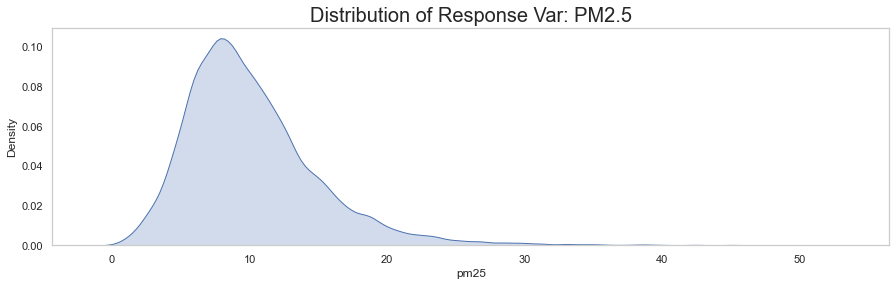

In [11]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_grp, x="pm25", bw_adjust=.8, fill=True).set_title("Distribution of Response Var: PM2.5", size=20)
print('')

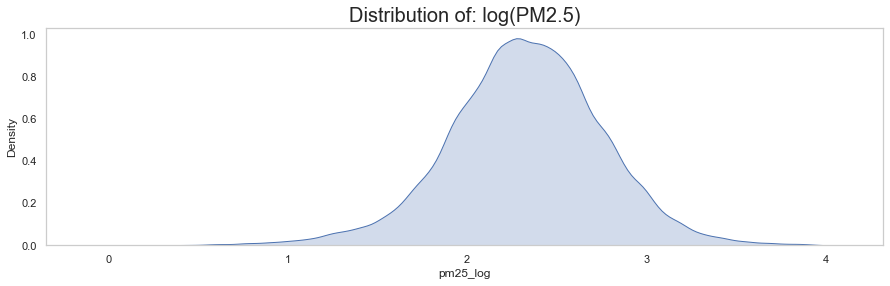

In [21]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_grp, x="pm25_log", bw_adjust=.8, fill=True)\
  .set_title("Distribution of: log(PM2.5)", size=20)
print('')

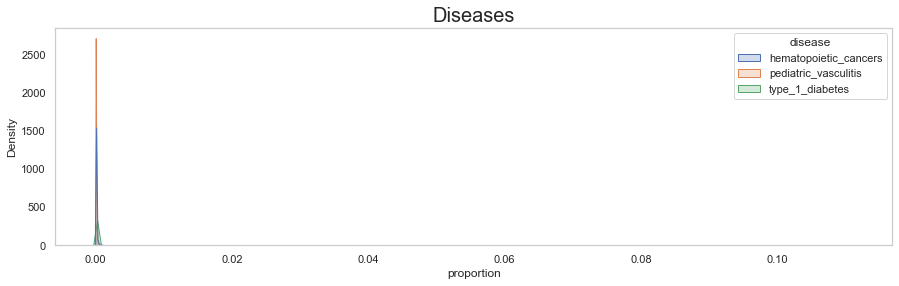

In [43]:
df_melt = pd.melt(df_grp, 
              value_vars=['hematopoietic_cancers', 'pediatric_vasculitis', 'type_1_diabetes'], 
              var_name='disease', value_name='proportion')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True)\
  .set_title("Diseases", size=20)
print('')

Just show positive cases

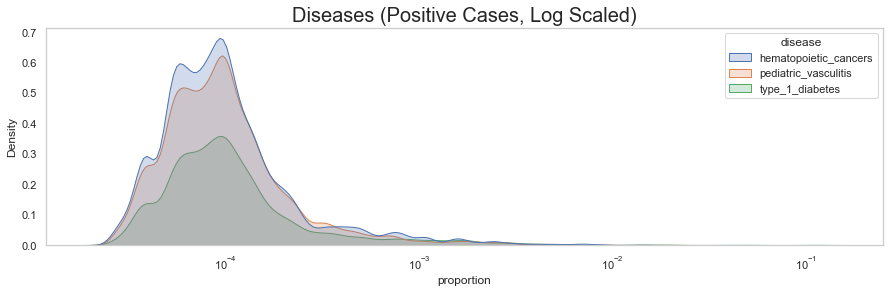

In [47]:
df_melt = pd.melt(df_grp, 
              value_vars=['hematopoietic_cancers', 'pediatric_vasculitis', 'type_1_diabetes'], 
              var_name='disease', value_name='proportion')
df_melt = df_melt[df_melt['proportion']>0]

sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Diseases (Positive Cases, Log Scaled)", size=20)
print('')

Univariate analysis

In [60]:
class FeatureStats:
  
  def __init__(self, df):
    self.df = df


  # method to get linear reg stats from any continuous feature
  def num_var_analyze(self, var, yvar='pm25'):
  
    df1 = self.df[[var, yvar]]
    
    # % missing
    percent_missing = df1[var].isna().sum() / df1.shape[0]
    
    # median impute
    df1[var] = df1[var].fillna(df1[var].median())
    
    # get lm metrics
    lm_model = LinearRegression() 
    lm_model.fit(X = df1[[var]], y=df1[yvar])
    yhat = lm_model.predict(df1[[var]])
    beta = lm_model.coef_[0]
    intercept = lm_model.intercept_
    ss_resid = sum((yhat - df1[yvar].values)**2)
    ss_total = sum((df1[yvar].mean() - df1[yvar].values)**2)
    r_squared = 1 - ss_resid / ss_total 
    
    output = {'var': [var], 'percent_missing': [percent_missing], 'beta': [beta], 'r_squared': [r_squared], 'intercept': [intercept]}
    return output
  
  
  def sort_num_features(self, var_list, yvar='pm25'):
    res_all = {}
    for var in var_list:
      res_i = self.num_var_analyze(var)
      
      if len(res_all) == 0:
        res_all = res_i.copy()
      else:
        for metric in ['var', 'percent_missing', 'beta', 'r_squared', 'intercept']:
          res_all[metric].append(res_i[metric][0])
    
    df_res = pd.DataFrame(res_all)
    df_res = df_res.sort_values('r_squared', ascending=False)
    
    return df_res
  
  
  def plot_num_features(self, var_list, yvar='pm25', show_missing_percent=False):
    
    ncol=2
    nrow = int(len(var_list) / ncol) + 1
    
    fig, ax = plt.subplots(nrow,ncol, figsize=(10*ncol, 5*nrow))
    
    # sort num features by r-squared
    sorted_features = self.sort_num_features(var_list)
    var_list = sorted_features['var'].to_list()
    
    var_i = 0
    for i in range(nrow):
      for j in range(ncol):
        
        if var_i+1 > len(var_list):
          break 
        
        var = var_list[var_i]
        
        # clean data
        df1 = self.df[[var, yvar]]
        df1[var] = df1[var].fillna(df1[var].median())
        
        # get regression details
        reg_results = self.num_var_analyze(var)
        
        # plot scatter 
        ax[i][j].scatter(df1[var], df1[yvar], alpha=.3, color='#3d7aba') # #f70eaa = lyft color
        
        # plot line
        xseq = np.linspace(df1[var].min(), df1[var].max(), num=100)
        yseq = reg_results['intercept'][0] + reg_results['beta'][0] * xseq
        xseq = xseq[yseq > 0]
        yseq = yseq[yseq > 0]
        ax[i][j].plot(xseq, yseq, color='k', lw=2.5)
        
        # set title
        if show_missing_percent:
          title_text = '{} | % missing: {:.2f} | beta: {:.1f} | $r^2$: {:.4f}'.format(
            var, reg_results['percent_missing'][0], reg_results['beta'][0], reg_results['r_squared'][0])
        else:
          title_text = '{} | beta: {:.1f} | $r^2$: {:.4f}'.format(var, reg_results['beta'][0], reg_results['r_squared'][0])
        
        ax[i][j].title.set_text(title_text)
        
        var_i += 1
    
    return fig.tight_layout()
  
  
  def cat_var_analyze(self, var, yvar='pm25'):
    
    df1 = self.df[[var, yvar]]
    
    df_plt = df1.copy()
    max_factor_levels = 5
    # if it's numeric and has more than 10 factor levels, bin it into [bracketed] bins
    if ((df_plt[var].dtypes == 'int') | (df_plt[var].dtypes == 'float')) & (len(set(df_plt[var])) > max_factor_levels):
      df_plt[var] = pd.qcut(df_plt[var], q=max_factor_levels, precision=2, duplicates='drop').to_list()
      # df_plot[var] = pd.cut(df_plot[var], bins=max_factor_levels, precision=2).to_list()
      df_plt[var] = df_plt[var].astype('string')
      df1 = df_plt.copy()
    
    df1[var] = df1[var].astype(str)

    def count_missing(var):
      num_na = df1[var].isna().sum()
      num_unknown = df1[var].map(lambda x: bool(re.search('unknown|no_data|missing', x.lower()))).sum()
      total_na = num_na + num_unknown
      
      return total_na
    
    # % missing
    percent_missing = count_missing(var) / df1.shape[0]
    
    # impute missing
    df1[var] = df1[var].fillna('missing')
    
    # one hot encode
    df1 = pd.get_dummies(df1)
    
    # rename columns
    #df1.columns = df1.columns.str.replace("\.*\s+", "_").str.lower()
    
    # run a linear reg
    X = df1.iloc[:,1:]
    X = sm.add_constant(X)
    y = df1[yvar]
    lm_fit = sm.OLS(y, X).fit() 
    lm_summary = lm_fit.summary()
    aic_ = lm_fit.aic
    bic_ = lm_fit.bic
    
    # save results 
    output = {'var': [var], 'percent_missing': [percent_missing], 'aic': [aic_], 'bic': [bic_]}
    return output
    
  
  def sort_cat_features(self, var_list, yvar='pm25', sort_by='aic', verbose=False):
    res_all = {}
    for var in var_list:
      if verbose:
        print(var)
        
      res_i = self.cat_var_analyze(var)
      
      if len(res_all) == 0:
        res_all = res_i.copy()
      else:
        for metric in ['var', 'percent_missing', 'aic', 'bic']:
          res_all[metric].append(res_i[metric][0])
    
    df_res = pd.DataFrame(res_all)
    df_res = df_res.sort_values(sort_by, ascending=True)
    
    return df_res
  
  
  def plot_cat_features(self, var_list, yvar='pm25', verbose=False, show_missing_percent=False):
    
    fig, axes = plt.subplots(len(var_list), 1, figsize=(15, 6 * len(var_list)))
  
    for i, var in enumerate(var_list):
      if verbose:
        print(var)
        
      df_plt = self.df[[yvar, var]]
      max_factor_levels = 5
      # if it's numeric and has more than 10 factor levels, bin it into [bracketed] bins
      if ((df_plt[var].dtypes == 'int') | (df_plt[var].dtypes == 'float')) & (len(set(df_plt[var])) > max_factor_levels):
          df_plt[var] = pd.qcut(df_plt[var], q=max_factor_levels, precision=2, duplicates='drop').to_list()
          # df_plot[var] = pd.cut(df_plot[var], bins=max_factor_levels, precision=2).to_list()
          df_plt[var] = df_plt[var].astype('string')
      
      df_plt = df_plt\
        .groupby(var)\
        .agg(**{'n': (var, 'count'), yvar: (yvar, 'mean')})\
        .reset_index()\
        .sort_values(var)
      
      # get lm stats
      res = self.cat_var_analyze(var)
      
      # plot
      x = np.arange(df_plt.shape[0])
      width=.7
      
      if len(var_list) == 1:
        ax = axes 
      else:
        ax = axes[i]
        
      ax.tick_params('x', labelrotation=-45)
      ax.plot(df_plt[var], df_plt[yvar], color='magenta', linestyle='-', marker='o', label=yvar)
      ax.set_ylabel(f'Mean {yvar}')
      ax_twin = ax.twinx()
      ax_twin.bar(df_plt[var], df_plt['n'], label="Count", color='darkgrey', width=12 / (df_plt.shape[0]*5))
      ax_twin.set_ylabel('Count')
      ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.2)
      ax_twin.set_ylim(ax_twin.get_ylim()[0], ax_twin.get_ylim()[1]*1.2)
      ax.legend(loc='upper left')
      ax_twin.legend(loc='upper right')
      ax.set_zorder(ax_twin.get_zorder() + 1)
      ax.patch.set_visible(False)
      ax.set_ylim(0, df_plt[yvar].max()*1.1)
      
      if show_missing_percent:
        title_t = '{} | AIC: {:.4} | BIC: {:.4} | Percent Missing: {:.0%}'.format(var, res['aic'][0], res['bic'][0], res['percent_missing'][0])
      else:
        title_t = '{} | AIC: {:.4} | BIC: {:.4}'.format(var, res['aic'][0], res['bic'][0])
      
      ax.set_title(title_t)
    
    fig.tight_layout()

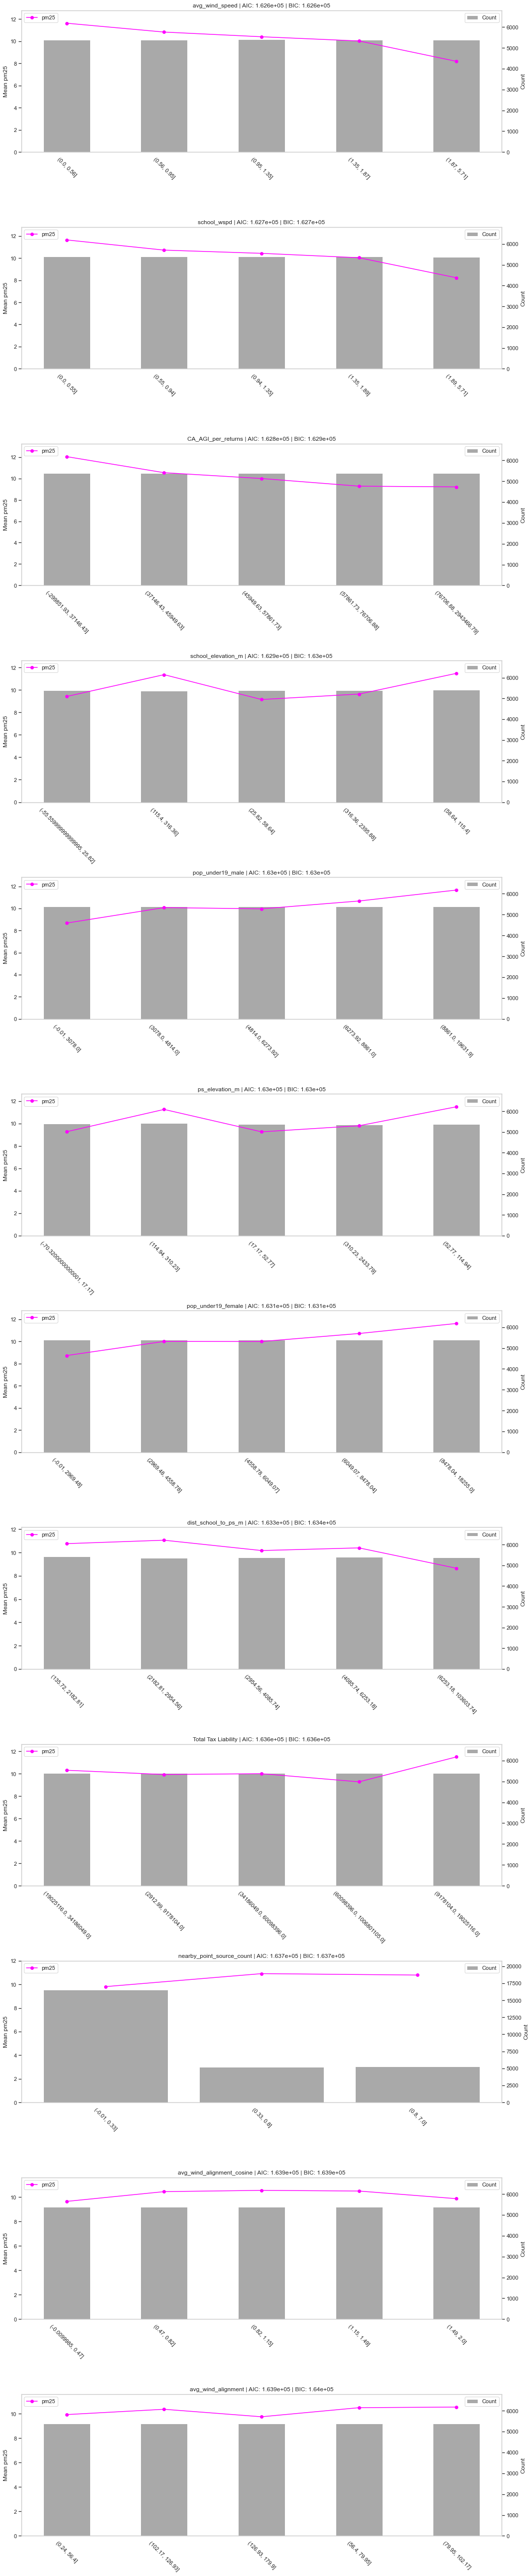

In [61]:
fs = FeatureStats(df_grp)
var_list = ['school_wspd', 'school_elevation_m', 'ps_elevation_m', 'pop_under19_male', 'pop_under19_female', 
  'dist_school_to_ps_m', 'avg_wind_speed', 'avg_wind_alignment_cosine', 
  'CA_AGI_per_returns', 'Total Tax Liability', 'nearby_point_source_count', 'avg_wind_alignment']
var_list2 = fs.sort_cat_features(var_list)
fs.plot_cat_features(var_list2['var'].to_list())
print('')

Plots for the log scaled PM2.5 look the same.

In [ ]:
# fs = FeatureStats(df_grp)
# var_list = ['school_wspd', 'school_elevation_m', 'ps_elevation_m', 'pop_under19_male', 'pop_under19_female', 
#   'dist_school_to_ps_m', 'avg_wind_speed', 'avg_wind_alignment_cosine']
# var_list2 = fs.sort_cat_features(var_list, yvar='pm25_log')
# fs.plot_cat_features(var_list2['var'].to_list(), yvar='pm25_log')
# print('')

# Aim 2 Regression = Predict pm2.5 levels

In [28]:
x_vars = ['school_wspd', 'school_elevation_m', 'ps_elevation_m', 'pop_under19_male', 'pop_under19_female', 
  'dist_school_to_ps_m', 'avg_wind_speed', 'avg_wind_alignment_cosine', 
  'CA_AGI_per_returns', 'Total Tax Liability', 'nearby_point_source_count']

X = df_grp[x_vars]
y = df_grp['pm25_log']

# add constant
X = sm.add_constant(X)

# fit
est = sm.OLS(y, X).fit()

# see summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               pm25_log   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     355.8
Date:                Sat, 15 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:56:06   Log-Likelihood:                -13953.
No. Observations:               26954   AIC:                         2.793e+04
Df Residuals:                   26942   BIC:                         2.803e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

# Aim 3 Regression

- Stage 1 of the least squares regression: $\hat{x} = z \delta$.
  - $\hat{x}$ = Predicted pm2.5 amounts ($\hat{pm2.5}$). We'll use this predicted var to predict our final Y, health outcomes. 
  - $z$ = Instrument. But this right hand side of the equation should also include all other exogenous (x) vars. 
  
- Stage 2 of the equation: $\hat{y} = \hat{x} \beta$
  - $\hat{y}$ = predicted medical outcome
  - $\hat{x}$ = predicted pm2.5 amt from the first stage. But we also should include the other exogenous vars. 

In [68]:
x_vars = ['school_wspd', 'school_elevation_m', 'ps_elevation_m', 'pop_under19_male', 'pop_under19_female', 
  'dist_school_to_ps_m', 'avg_wind_speed', 'avg_wind_alignment_cosine', 
  'CA_AGI_per_returns', 'Total Tax Liability', 'nearby_point_source_count']

X = df_grp[x_vars]
y = df_grp['pm25']



IV2SLS(
  endog='pm25_log',
  exog=X,
  instrument='avg_wind_alignment_cosine'
  )

AttributeError: 'str' object has no attribute 'ndim'

# Modeling with more complex relationship. 

Now, model $\hat{x}$ using a more complex ML algo such as xgb. Then use that $\hat{x}$ in the 2nd stage least squares regression. 